In [1]:
import re

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from ast import literal_eval
from collections import OrderedDict

%matplotlib inline

In [2]:
X = pd.read_csv('./../../../data_source/to_analysis/no_filter_concat.csv', index_col=0)
features = list(X.columns)
features[:6]

['original_shape_Elongation',
 'original_shape_Flatness',
 'original_shape_LeastAxis',
 'original_shape_MajorAxis',
 'original_shape_Maximum2DDiameterColumn',
 'original_shape_Maximum2DDiameterRow']

In [3]:
results = pd.read_csv('./../../../data_source/results/baseline_nofilter_sffs_40vals_10reps_dfs.csv', index_col=0)
results.head()

,exp_duration,exp_id,experiment_id,feature_votes,test_score,test_score_variance,train_score,train_score_variance
0,0 days 00:08:17.164633000,72,StudentTTestSelection_DTreeEstimator,[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 0 0...,0.563604,0.003285,0.617035,0.000150
1,0 days 00:10:34.961865000,370,StudentTTestSelection_DTreeEstimator,[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 3 4 2...,0.484544,0.012276,0.593987,0.000461
2,0 days 00:12:01.024077000,159,StudentTTestSelection_DTreeEstimator,[4 3 5 5 5 5 3 4 5 5 5 5 4 5 5 4 4 5 2 5 4 4 5...,0.608974,0.002561,0.764614,0.000233
3,0 days 00:09:19.561337000,805,StudentTTestSelection_DTreeEstimator,[4 4 5 3 4 5 4 4 2 4 4 4 4 5 2 4 4 4 5 4 2 2 3...,0.532407,0.010907,0.639681,0.000385
4,0 days 00:11:44.868641000,728,StudentTTestSelection_DTreeEstimator,[4 1 2 3 5 3 3 5 3 4 4 4 3 4 0 5 3 2 3 2 4 4 3...,0.495584,0.001928,0.836357,0.000210


In [4]:
votes = results['feature_votes']
votes.head()

0    [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 0 0...
1    [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 3 4 2...
2    [4 3 5 5 5 5 3 4 5 5 5 5 4 5 5 4 4 5 2 5 4 4 5...
3    [4 4 5 3 4 5 4 4 2 4 4 4 4 5 2 4 4 4 5 4 2 2 3...
4    [4 1 2 3 5 3 3 5 3 4 4 4 3 4 0 5 3 2 3 2 4 4 3...
Name: feature_votes, dtype: object

In [5]:
# Goal:
# * Sort votes and collect corresponding labels.

global_votes = np.zeros(X.shape[1], dtype=int)
for str_array in votes:
    _votes = list(str_array.replace(' ', '').replace('\n', ''))
    votes_arr = np.array(list(map(int, list(_votes[1:-1]))), dtype=int)
    global_votes += votes_arr

idx = np.argsort(global_votes)[::-1]
labels = np.array(features)[idx]
sorted_votes = np.trim_zeros(global_votes[idx], trim='b')
labels = labels[:len(sorted_votes)]


data = pd.DataFrame(
    {
        'votes': sorted_votes,
        'labels': labels,
        
    }
)
data.head()

,votes,labels
0,371,original_shape_Elongation
1,363,original_shape_LeastAxis
2,359,original_shape_Flatness
3,343,original_shape_Maximum2DDiameterColumn
4,339,original_shape_MajorAxis


In [6]:
# Sanity check.
max(global_votes), sorted_votes[0]

(371, 371)

In [7]:
len(global_votes), len(sorted_votes)

(610, 93)

In [8]:
def prep_feature_labels(labels):
    prep_labels = []
    for label in labels:
        comps = label.split('_')

        if len(comps) == 1:
            prep_labels.append(label.title())
        elif len(comps) == 2:
            new_label = '{}: {}'.format(comps[0], comps[1])
        elif len(comps) == 3:
            filter_type, feature_type, name = comps
            if len(name) > 15:
                #name_comps = re.findall('[A-Z][^A-Z]*', name)
                #name = ('-\n').join((('').join(name_comps[:2]), ('').join(name_comps[2:])))
                new_label = '{}'.format(name)
            else:
                new_label = '{}'.format(name)
            prep_labels.append(new_label)
        elif len(comps) == 4:
            image_type, filter_type, feature_type, name = comps
            if len(name) > 15:
                #name_comps = re.findall('[A-Z][^A-Z]*', name)
                #name = ('-\n').join((('').join(name_comps[:2]), ('').join(name_comps[2:])))
                new_label = '\n{}'.format(name)
            else:
                new_label = '{}'.format(name)
            prep_labels.append(new_label)
            
    return prep_labels

In [9]:
def feature_labels(labels):    
    
    keys = []
    for label in labels:
        if 'shape' in label:
            keys.append('Shape')
        elif 'firstorder' in label:
            keys.append('First Order')
        elif 'glcm' in label:
            keys.append('GLCM')
        elif 'glrlm' in label:
            keys.append('GLRLM')
        elif 'glszm' in label:
            keys.append('GLSZM')
        elif 'gldm' in label:
            keys.append('GLDM')
        elif 'ngtdm' in label:
            keys.append('NGTDM')
        elif 'PETparam' in label:
            keys.append('PET parameter')
        else:
            keys.append('Clinical')
    return keys

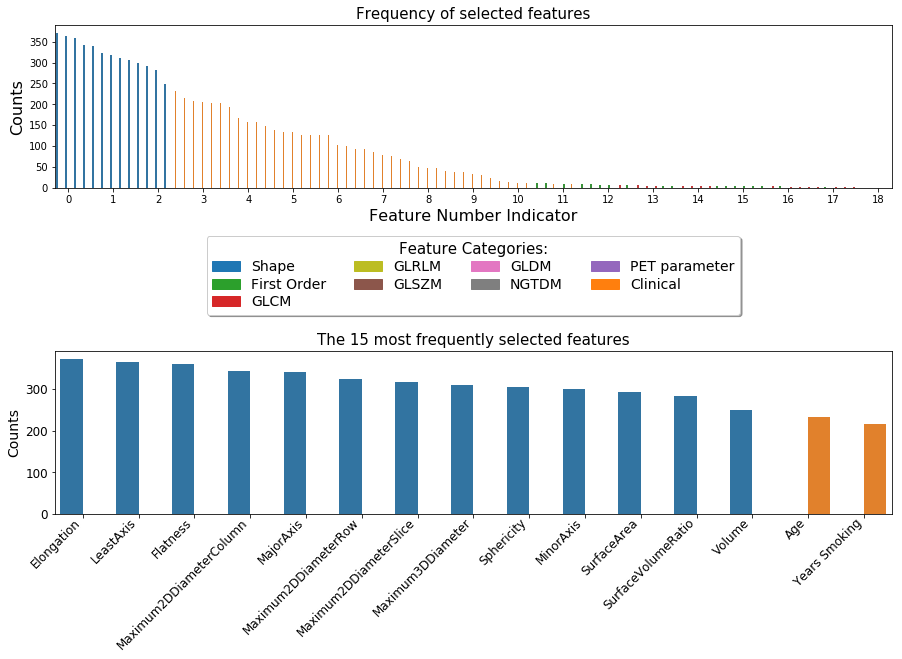

In [10]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 9))
plt.tick_params(axis='both', labelsize=12)
prep_labels = [
    'Shape', 
    'First Order', 
    'GLCM', 
    'GLRLM', 
    'GLSZM', 
    'GLDM', 
    'NGTDM', 
    'PET parameter',
    'Clinical'
]
colours = OrderedDict(
    [
        ('Shape', sns.color_palette()[0]),
        ('Clinical', sns.color_palette()[1]),
        ('First Order', sns.color_palette()[2]),
        ('GLCM', sns.color_palette()[3]),
        ('GLRLM', sns.color_palette()[8]),
        ('GLSZM', sns.color_palette()[5]),
        ('GLDM', sns.color_palette()[6]),
        ('NGTDM', sns.color_palette()[7]),
        ('PET parameter', sns.color_palette()[4])
    ]
)
keys = feature_labels(labels)
handles = [
    mpatches.Patch(color=colours[key], label=key) for key in prep_labels
]
sns.barplot(
    x=np.arange(np.size(sorted_votes)), 
    y=sorted_votes, 
    ax=axes[0], 
    hue=keys,
    palette=colours,
)
feature_id = range(1, sorted_votes.size, 5)
axes[0].set_title('Frequency of selected features', fontsize=15)
axes[0].set_xticks(feature_id)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_xlabel('Feature Number Indicator', fontsize=16)
axes[0].legend(
    handles=handles,
    title='Feature Categories:', 
    title_fontsize=15,
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.25), 
    fancybox=True, 
    shadow=True, 
    fontsize=14,
    ncol=4,
    labelspacing=0.25
)

n = 15
keys = feature_labels(labels[:n])
sns.barplot(
    x=np.arange(np.size(sorted_votes[:n])), 
    y=sorted_votes[:n], 
    ax=axes[1], 
    hue=keys,
    palette=colours,
)
fnames = prep_feature_labels(labels[:n])
axes[1].legend().set_visible(False)
axes[1].set_title('The {} most frequently selected features'.format(n), fontsize=15)
axes[1].set_xticklabels(fnames, rotation=45, ha='right', va='center_baseline')
axes[1].set_ylabel('Counts', fontsize=14)

plt.subplots_adjust(hspace=1)

plt.savefig(
    './../../../figures/biomarkers.png',
    bbox_inches='tight',
    transparent=True,
    dpi=600, 
)

In [11]:
cats = ['shape',
        'firstorder',
        'glcm',
        'glrlm',
        'glszm',
        'gldm',
        'ngtdm']
res = {}
for cat in cats:
    p = 0
    c = 0
    for label in labels:
        if cat in label:
            c = c + 1
    res[cat] = c
            
res

{'shape': 13,
 'firstorder': 18,
 'glcm': 20,
 'glrlm': 0,
 'glszm': 0,
 'gldm': 0,
 'ngtdm': 0}

In [12]:
# NOTE: Num clinical features.
len(labels) - sum(res.values())

42

In [13]:
len(list(X.filter(regex='shape').columns))

13

In [14]:
len(list(X.filter(regex='CT').columns))

276

In [15]:
len(list(X.filter(regex='PET').columns))

279

In [16]:
nogos = list(X.filter(regex='shape').columns) 
nogos = nogos + list(X.filter(regex='CT').columns) 
nogos = nogos + list(X.filter(regex='PET').columns)

cols = []
for col in X.columns:
    if col not in nogos:
        cols.append(col)
cols

['Age',
 'Years Smoking',
 'Naxogin Days',
 'Sex_M',
 'ICD-10_C02',
 'ICD-10_C03',
 'ICD-10_C04',
 'ICD-10_C05',
 'ICD-10_C06',
 'ICD-10_C09',
 'ICD-10_C10',
 'ICD-10_C12',
 'ICD-10_C13',
 'ICD-10_C32',
 'T Stage_2',
 'T Stage_3',
 'T Stage_4',
 'N Stage_1',
 'N Stage_2',
 'N Stage_3',
 'Histology_1.0',
 'Histology_2.0',
 'Histology_3.0',
 'HPV_1',
 'HPV_2',
 'ECOG_1',
 'ECOG_2',
 'Charlson_1',
 'Charlson_2',
 'Charlson_3',
 'Charlson_4',
 'Charlson_5',
 'Cisplatin_1',
 'Cisplatin_2',
 'Cisplatin_3',
 'Cisplatin_4',
 'Cisplatin_5',
 'Cisplatin_6',
 'Stage 1',
 'Stage 2',
 'Stage 3',
 'Stage 4']

In [17]:
len(cols)

42

In [18]:
len(cols) + len(nogos)

610

In [19]:
list(X.filter(regex='PET').columns)

['PET_original_firstorder_10Percentile',
 'PET_original_firstorder_90Percentile',
 'PET_original_firstorder_Energy',
 'PET_original_firstorder_Entropy',
 'PET_original_firstorder_InterquartileRange',
 'PET_original_firstorder_Kurtosis',
 'PET_original_firstorder_Maximum',
 'PET_original_firstorder_MeanAbsoluteDeviation',
 'PET_original_firstorder_Mean',
 'PET_original_firstorder_Median',
 'PET_original_firstorder_Minimum',
 'PET_original_firstorder_Range',
 'PET_original_firstorder_RobustMeanAbsoluteDeviation',
 'PET_original_firstorder_RootMeanSquared',
 'PET_original_firstorder_Skewness',
 'PET_original_firstorder_TotalEnergy',
 'PET_original_firstorder_Uniformity',
 'PET_original_firstorder_Variance',
 'PET_original_glcm_Autocorrelation',
 'PET_original_glcm_ClusterProminence',
 'PET_original_glcm_ClusterShade',
 'PET_original_glcm_ClusterTendency',
 'PET_original_glcm_Contrast',
 'PET_original_glcm_Correlation',
 'PET_original_glcm_DifferenceAverage',
 'PET_original_glcm_Difference

In [21]:
list(labels)

['original_shape_Elongation',
 'original_shape_LeastAxis',
 'original_shape_Flatness',
 'original_shape_Maximum2DDiameterColumn',
 'original_shape_MajorAxis',
 'original_shape_Maximum2DDiameterRow',
 'original_shape_Maximum2DDiameterSlice',
 'original_shape_Maximum3DDiameter',
 'original_shape_Sphericity',
 'original_shape_MinorAxis',
 'original_shape_SurfaceArea',
 'original_shape_SurfaceVolumeRatio',
 'original_shape_Volume',
 'Age',
 'Years Smoking',
 'Naxogin Days',
 'ICD-10_C02',
 'Sex_M',
 'ICD-10_C04',
 'ICD-10_C03',
 'ICD-10_C05',
 'ICD-10_C06',
 'ICD-10_C09',
 'ICD-10_C10',
 'ICD-10_C13',
 'ICD-10_C12',
 'ICD-10_C32',
 'T Stage_4',
 'N Stage_1',
 'T Stage_3',
 'T Stage_2',
 'N Stage_3',
 'N Stage_2',
 'Histology_1.0',
 'Histology_2.0',
 'Histology_3.0',
 'HPV_1',
 'HPV_2',
 'ECOG_1',
 'ECOG_2',
 'Charlson_1',
 'Charlson_2',
 'Charlson_3',
 'Charlson_4',
 'Charlson_5',
 'Cisplatin_2',
 'Cisplatin_1',
 'Cisplatin_3',
 'Cisplatin_4',
 'Stage 3',
 'Stage 4',
 'Cisplatin_5',
 'Stag